# GRANDMA/Kilonova-catcher --- KN-Rate-based

The purpose of this notebook is to inspect the ZTF alerts that were selected by the Fink KN-Rate-Based filter as potential Kilonova candidates in the period 2021/04/01 to 2021/08/31. This filter was not used in the campaign as we need to understand a bit more the output.

One of the criteria that we are using to evaluate the quality of the classifier-based filter is the slope of the light curve, designed as the rate in the following. Given this observation, we may want to consider a filter that would use a threshold on the rate as a criterion instead of the classifier. Given the expected light curves of kilonovae, the threshold chosen is 0.3 mag/day [1], which corresponds to a fast-fading object.
Given the usual uncertainty on the points, using only the slope between the last two points gives very inconsistent and irrelevant results. The points are often at the end of a long light curve that matches another transient. One could diminish the number of tolerated detections from 20 to two or three but averaging the rate on the whole light curve should give a more general result that would be more robust than using two points. In practice, the objects that have such a rate are very specific. The number of detections varies a lot depending on the month of observation, but the observed candidates are mostly stellar flares in the band g. Despite additional cross-match with star catalogs, we still obtain such candidates from uncatalogued stars. There are a few interesting candidates, but the number of false positives has to be reduced for this filter to be interesting.

[1] Igor Andreoni et al. Fast-transient Searches in Real Time with ZTFReST: Identification of Three Optically-discovered Gamma-ray Burst Afterglows and New Constraints on the Kilonova Rate. 2021. arXiv: 2104.06352

In [1]:
import os
import requests

import pandas as pd
import numpy as np

from scipy.optimize import curve_fit

# pip install fink_science
from fink_science.conversion import dc_mag

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://fink-portal.org'

## KN-Rate-Based data

Let's load the alert data from this filter:

In [3]:
pdf_kn_rb = pd.read_parquet('data/0104_3009_kn_filter3_class.parquet')

nalerts_kn_rb = len(pdf_kn_rb)
nunique_alerts_kn_rb = len(np.unique(pdf_kn_rb['objectId']))

print(
    '{} alerts loaded ({} unique objects)'.format(
        nalerts_kn_rb, 
        nunique_alerts_kn_rb
    )
)

127 alerts loaded (108 unique objects)


## Visualising the candidates

Finally, let's inspect one lightcurve:

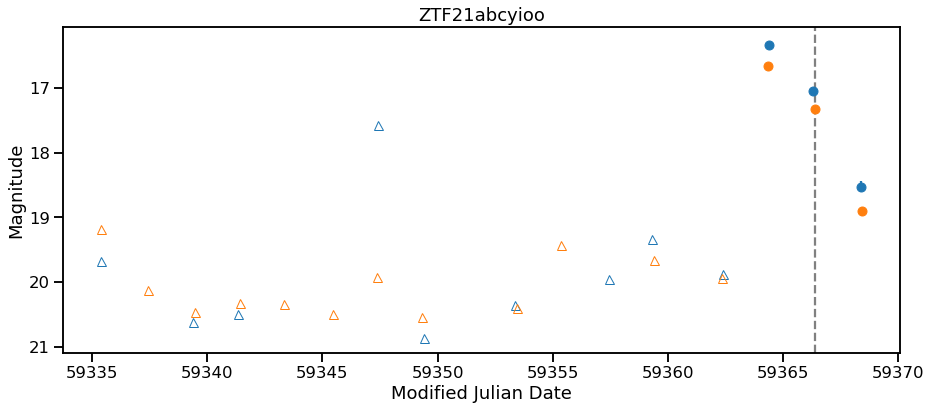

https://fink-portal.org/ZTF21abcyioo


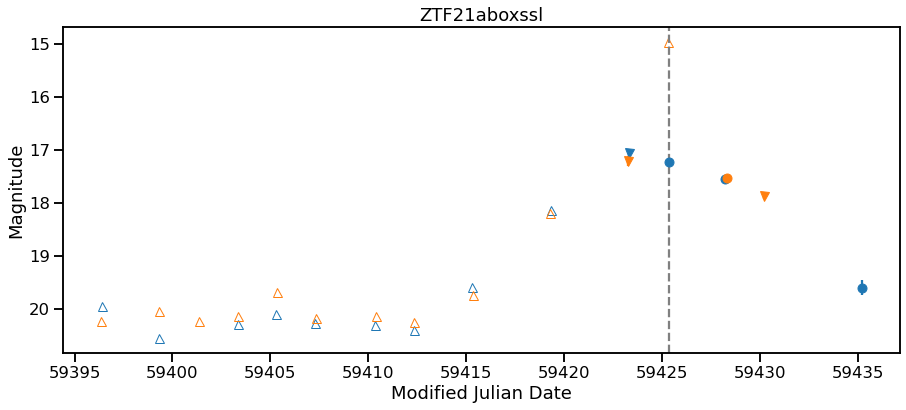

https://fink-portal.org/ZTF21aboxssl


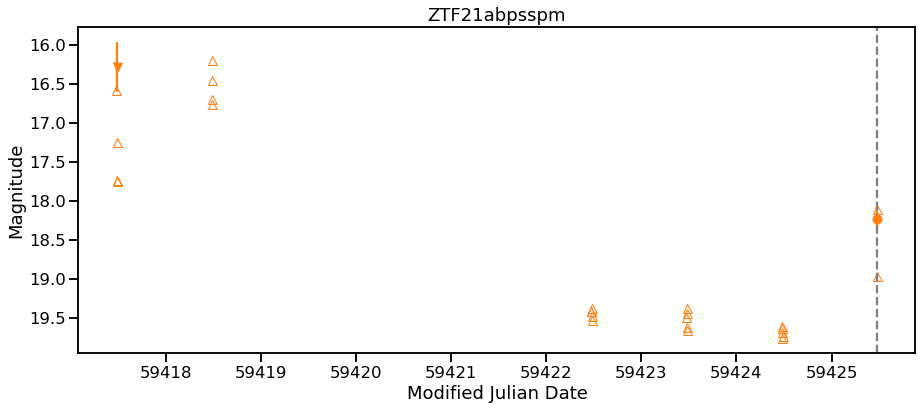

https://fink-portal.org/ZTF21abpsspm


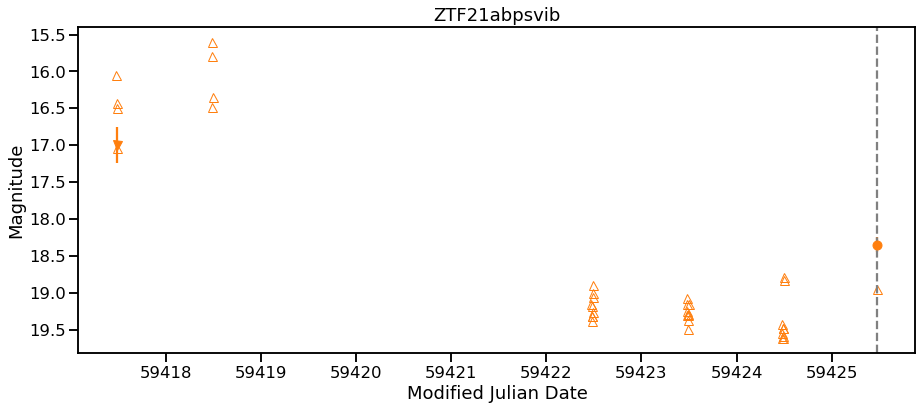

https://fink-portal.org/ZTF21abpsvib


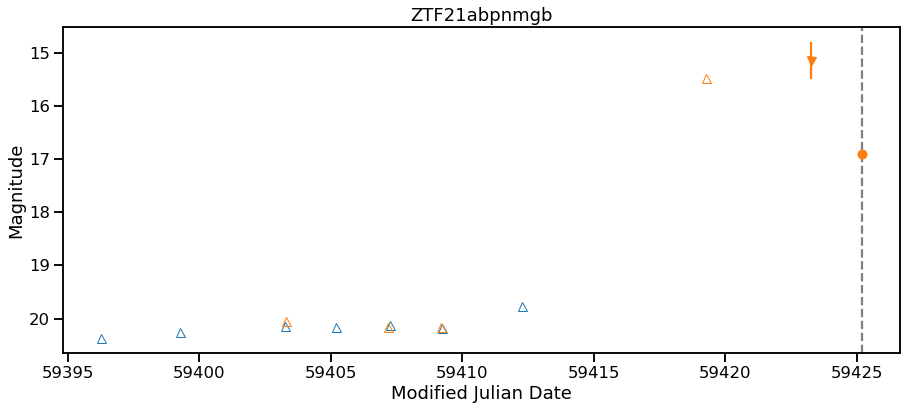

https://fink-portal.org/ZTF21abpnmgb


In [4]:
oids = pdf_kn_rb['objectId'].values[:5]
tns_classes = pdf_kn_rb['TNS'].values[:5]
kn_triggers = pdf_kn_rb['candidate'].apply(lambda x: x['jd']).values[:5]

for oid, tns_class, kn_trigger in zip(oids, tns_classes, kn_triggers):
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'withupperlim': 'True'
      }
    )

    # Format output in a DataFrame
    pdf = pd.read_json(r.content)

    fig = plt.figure(figsize=(15, 6))

    colordic = {1: 'C0', 2: 'C1'}

    for filt in np.unique(pdf['i:fid']):
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='^', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='v', color=colordic[filt]
        )

    plt.axvline(kn_trigger - 2400000.5, ls='--', color='grey')
    plt.gca().invert_yaxis()
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.title('{}'.format(oid))
    plt.show()
    print('{}/{}'.format(APIURL, oid))

Circles (●) with error bars show valid alerts that pass the Fink quality cuts. Upper triangles with errors (▲), representing alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers. Lower triangles (▽), representing 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts. The vertical line shows the KN trigger by Fink.

## Time delay

(array([ 1., 86.,  0., 10.,  3., 10.,  7.,  0.,  1.,  4.,  1.,  2.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 1.0064699 ,  1.60385532,  2.20124074,  2.79862616,  3.39601158,
         3.993397  ,  4.59078242,  5.18816784,  5.78555326,  6.38293868,
         6.9803241 ,  7.57770952,  8.17509494,  8.77248036,  9.36986578,
         9.9672512 , 10.56463662, 11.16202204, 11.75940746, 12.35679288,
        12.9541783 ]),
 <a list of 20 Patch objects>)

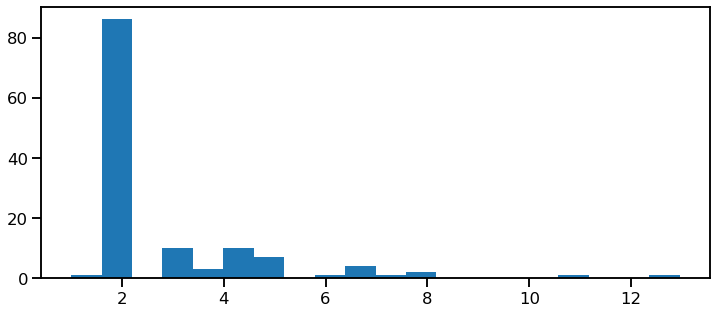

In [5]:
delay = pdf_kn_rb['candidate'].apply(lambda x: x['jd'] - x['jdstarthist'])
fig = plt.figure(figsize=(12, 5))
plt.hist(delay, bins=20)

## Evolution of the classification

Each alert was triggered because the Fink pipelines favoured the KN flavor at the time of emission. But the underlying object on the sky might have generated further alerts after, and the classification could evolve. For a handful of alerts, let see what they became. For this, we will use the Fink REST API, and query all the data for the underlying object:

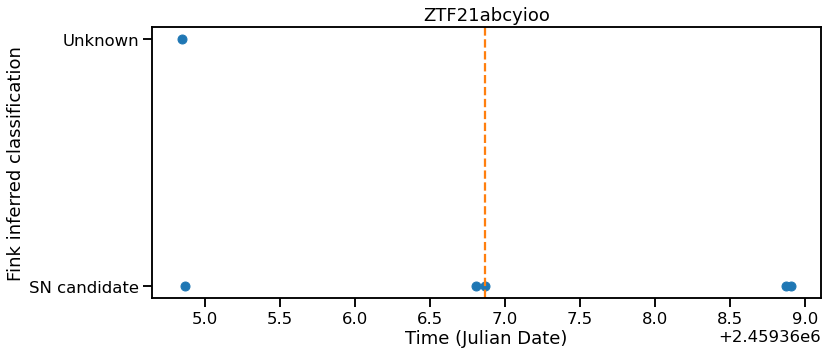

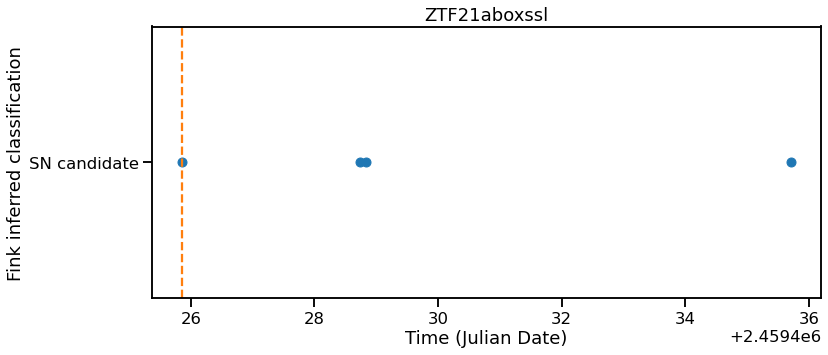

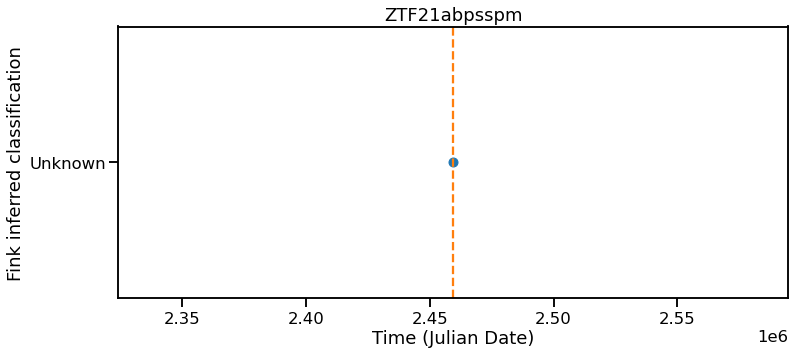

In [6]:
NALERTS = 3
oids = pdf_kn_rb['objectId'].values[0: NALERTS]
kn_triggers = pdf_kn_rb['candidate'].apply(lambda x: x['jd']).values[0: NALERTS]

for oid, kn_trigger in zip(oids, kn_triggers):
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'output-format': 'json'
      }
    )

    # Format output in a DataFrame
    pdf_ = pd.read_json(r.content)
    times, classes = np.transpose(pdf_[['i:jd','v:classification']].values)
    
    fig = plt.figure(figsize=(12, 5))
    
    plt.plot(times, classes, ls='', marker='o')
    plt.axvline(kn_trigger, ls='--', color='C1')
    
    plt.title(oid)
    plt.xlabel('Time (Julian Date)')
    plt.ylabel('Fink inferred classification')
    plt.show()

Note that Kilonova classification does not appear here as this label is reserved to the KN-LC filter. We are working on giving a new label. 

One can see that alert classification for a given object can change over time. With time, we collect more data, and have a clearer view on the nature of the object. Let's make an histogram of the final classification for each object (~1min to run)

In [7]:
final_classes = []
oids = np.unique(pdf_kn_rb['objectId'].values)
for oid in oids:
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'output-format': 'json'
      }
    )
    pdf_ = pd.read_json(r.content)
    final_classes.append(pdf_['v:classification'].values[0])

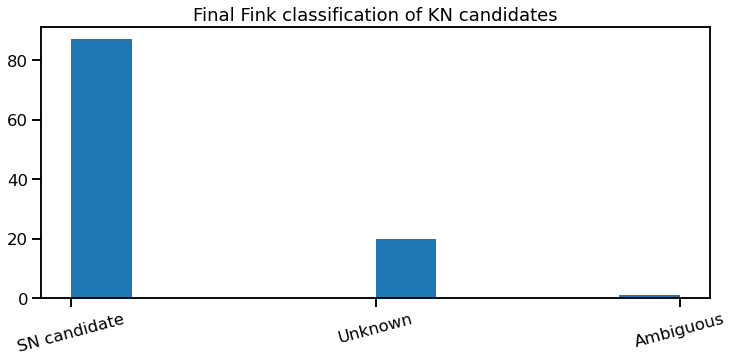

In [8]:
fig = plt.figure(figsize=(12, 5))

plt.hist(final_classes)

plt.xticks(rotation=15.)
plt.title('Final Fink classification of KN candidates');

Most of the objects are considered as SN candidates according to Fink.

## Follow-up of candidates by other instruments

Some of the alerts benefited from follow-up by other instruments to determine their nature. Usually this information can be found on the TNS server (although this is highly biased towards Supernovae). We attached this information to the alerts (if it exists):

In [9]:
pdf_kn_rb.groupby('TNS').count().sort_values('objectId', ascending=False)['objectId']

TNS
          117
CV          6
SN Ia       3
SN IIn      1
Name: objectId, dtype: int64

## Rate

Computing a rate is tricky as the data is noisy. We present here two methods:

1. Naive method: take the difference magnitude measurements, and compute the rate using the last 2 measurements in a band.
2. Robust method: take the apparent magnitude measurements, and compute the rate using all the measurements in a band.

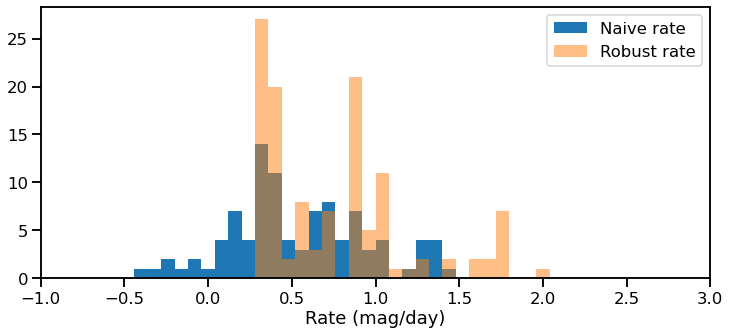

In [12]:
fig = plt.figure(figsize=(12, 5))

mags = pdf_kn_rb['cmagpsfc']
errs = pdf_kn_rb['csigmapsfc']
filts = pdf_kn_rb['cfidc']
jds = pdf_kn_rb['cjdc']
magnrs = pdf_kn_rb['cmagnrc']
sigmanrs = pdf_kn_rb['csigmagnrc']
magzpscis = pdf_kn_rb['cmagzpscic']
isdiffposs = pdf_kn_rb['cisdiffposc']

rates = []
rates2 = []
for mag, err, filt, jd, magnr, sigmanr, magzpsci, isdiffpos in zip(mags, errs, filts, jds, magnrs, sigmanrs, magzpscis, isdiffposs):
    maskNotNone = mag == mag

    last_filt = filt[-1]
    mask = filt == last_filt
    
    # Compute naive rate (difference between last two measurements in a band)
    diff_mag = mag[mask][-1] - mag[mask][-2]
    diff_jd = jd[mask][-1] - jd[mask][-2]
    rate = diff_mag / diff_jd
    
    # Compute proper rate using DC mag, and all the measurements in a band
    # Diff mag to DC mag (history + last measurement)
    mag_, err_ = np.array([
        dc_mag(k[0], k[1], k[2], k[3], k[4], k[5], k[6])
        for k in zip(
            filt,
            mag,
            err,
            magnr,
            sigmanr,
            magzpsci,
            isdiffpos,
        )
    ]).T
    
    popt, pcov = curve_fit(
        lambda x, a, b: a*x + b,
        jd[mask*maskNotNone],
        mag_[mask*maskNotNone],
        sigma=err_[mask*maskNotNone],
    )
    
    rate2 = popt[0]
    
    if np.abs(rate) > 2:
        rates.append(np.nan)
        rates2.append(np.nan)
    else:
        rates.append(rate)
        rates2.append(rate2)


plt.hist(rates, bins=50, range=[-1, 3], label='Naive rate')
plt.hist(rates2, bins=50, range=[-1, 3], label='Robust rate', alpha=0.5)

plt.xlim(-1, 3)
plt.xlabel('Rate (mag/day)')
plt.legend()

plt.show()